# Cats vs Dogs
This notebook is an updated version of the given model. Made by Kira De Ketelaere, with help of AI assistents.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


## Load libraries and the data

In [2]:
base_dir = "/kaggle/working"

In [3]:
import numpy as np
import sys
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image

import torchvision
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchmetrics

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.2
torchvision version: 0.16.2


In [4]:
class CatDogDataset(Dataset):

    def __init__(self, train_dir, transform = None):
        
        self.train_dir = train_dir
        self.transform = transform
        self.images = os.listdir(train_dir)
        

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.train_dir, self.images[index])
        label = self.images[index].split(".")[0]

        label = 0 if label == 'cat' else 1
        image = np.array(Image.open(image_path))
        
        if self.transform is not None:
            image = Image.fromarray(image)
            image = self.transform(image)

        return image, label

In [5]:

'''
transform = transforms.Compose([
    Resize((100, 100)),          # Resize images to 128x128
    ToTensor()                  # Convert images to PyTorch tensors
])
Do some data augmentation '''
test_transform = transforms.Compose([
    Resize((100, 100)),          # Resize images to 128x128
    ToTensor()                  # Convert images to PyTorch tensors
])

train_transform = transforms.Compose([
    ToTensor(),
    Resize((100,100)),
    transforms.RandomHorizontalFlip(p=0.2),  # Keep random horizontal flip
    transforms.RandomRotation(10) # Rotate by up to 10 degrees
    ])



In [6]:
!unzip -qq /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip 
!unzip -qq /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip

In [7]:
#load test and train
#use CatDogDataset to transform the data and split data into images and labels
train_dir = "train" #name of folder with training data in base_dir 
test_dir = "test" #name of folder with test data in base_dir
train_data =CatDogDataset(train_dir, transform=train_transform) 
test_data = CatDogDataset(test_dir, transform=test_transform)

## Look at the data

In [8]:
len(train_data), len(test_data) #how many images are in the training and test data

(25000, 12500)

In [9]:
#look at the shape of data
image, label = train_data[0] #get the first image and label
image.shape

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 100, 100])

torch.Size([3, 100, 100]) means that it is a tensor with 3 color channels (RGB) and a pixel size of 100x100 (WxH) as decided in the transformer.

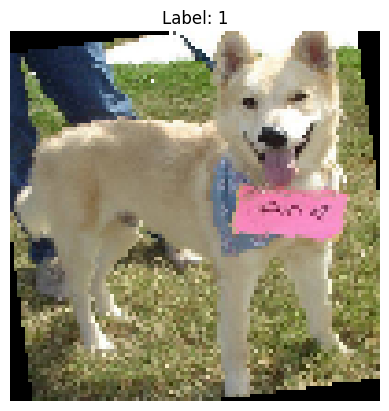

In [10]:
image, label = train_data[0] # Get the first image and its label

# Permute the tensor from [C, H, W] to [H, W, C]
image = image.permute(1, 2, 0)

plt.imshow(image) # Show the image
plt.title(f"Label: {label}") # Set the title of the image with the correct label
plt.axis('off') # Hide the axes
plt.show() 

## Prepare data for training
Split the training set in a train and a validation set. As seen before there are 25 000 images in the dataset. Use 20 000 for the training and 5000 for the validation.

In [11]:
train_dataset, validation_dataset = torch.utils.data.random_split(train_data, [20000, 5000])
len(train_dataset),  len(validation_dataset)

(20000, 5000)

Split this data into batches and load it with the DataLoader to be able to iterate over the data in batches. Put shuffle on true to make sure that the batches have data from everywhere in the training dataset.

In [12]:
BATCH_SIZE = 32 #define the batch size

train_dataloader = DataLoader(train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True #shuffle the training data
)

validation_dataloader = DataLoader(validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True 
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False #no need to shuffle the test data
)

In [13]:
#Look what the dataloader does to the data
def inspect_data_loader(data_loader):
  """
  Inspects the shape of the first batch from a data loader.

  Args:
      data_loader: A PyTorch DataLoader object.

  Returns:
      None (prints the shapes to the console)
  """
  images, labels = next(iter(data_loader))
  print("Batch 1:")
  print("Images shape:", images.shape)
  print("Label shape:", labels.shape)

# Usage
inspect_data_loader(train_dataloader)  # Call the function for training data

Batch 1:
Images shape: torch.Size([32, 3, 100, 100])
Label shape: torch.Size([32])


Hereby verified that the batches contain of 32 images and that the images still have 3 color channels and are of pixel size 100x100. The labels also consist of batches of 32 that fit the images.

In [14]:
len(train_dataset)/BATCH_SIZE, len(validation_dataset)/BATCH_SIZE, len(test_data)/BATCH_SIZE

(625.0, 156.25, 390.625)

Look how many batches there are for the different datasets. The train_dataset has 625 batches, the validation dataset has 157 batches and the test data has 391 batches of 32 images.

Now look at a flatten function. What does it do? it flattens the 3D tensor into a 1D tensor.

In [15]:
#what does flatten do?
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x, y = train_dataset[0] #x = input data = image; y = label (cat or dog)

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]") #normal shape as before
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]") #flattened shape, should be 3, 10000

Shape before flattening: torch.Size([3, 100, 100]) -> [color_channels, height, width]
Shape after flattening: torch.Size([3, 10000]) -> [color_channels, height*width]


In [16]:
class CNN(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default, how many pixels the filter moves each time
                      padding=1), # default, how many pixels are added to the image to make sure the filter can cover the entire image
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flatten the output of the convolutional layers as shown above
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*25*25, #to match shape of output of flatten
                      out_features=output_shape),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor): #forward pass
        x = self.block_1(x) # pass the input through the first block
        x = self.block_2(x) # pass the input through the second block
        x = self.classifier(x) # pass the input through the classifier
        return x

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [18]:
model = CNN(input_shape= 3, # 3 color channels
    hidden_units=10, # number of filters
    output_shape=1).to(device) # 1 output neuron

In [19]:
metric = torchmetrics.Accuracy(task="binary").to(device) #define the metric to use
#parameters
learning_rate = 0.001 #learning rate, put on 0.001 because it is default of Adam optimizer
weight_decay = 0.0001 #weight decay, put on 0.0001 because it is default of Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay) #use Adam optimizer because it is good for binary classification
loss_function = nn.BCELoss() #use Binary Cross Entropy Loss, because it is good for binary classification
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2) #use ReduceLROnPlateau, mode='max' to increase the learning rate when the validation accuracy stops improving.g

In [20]:
def train_loop(train_dataloader, validation_dataloader, num_epochs, save_path):
    #best_val_loss = float('inf')  # Initialize with a very large number
    best_val_acc = 0.0 # Initialize with 0
    best_epoch = 0 # Initialize with 0
    model.train() # Set the model to train mode

    # Define the learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2) # Reduce learning rate when a metric has stopped improving

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}") #follow the progress of the training
        train_loss = 0
        for batch, (X, y) in enumerate(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            predictions_train = model(X) # Forward pass
            loss = loss_function(predictions_train, y.float().view(-1, 1)) # Compute loss
            train_loss += loss # Accumulate loss
            optimizer.zero_grad() # Zero gradients from previous iteration
            loss.backward() # Backward pass
            optimizer.step() # Optimize by one step


            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch+1}/{len(train_dataloader)}: Loss: {loss.item():.3f}", end="\r") #follow the progress of the training

        train_loss /= len(train_dataloader)

        model.eval()
        val_loss = 0
        with torch.no_grad(): # Disable gradient tracking, make sure that model is in evaluation mode 
            for X, y in validation_dataloader:
                X = X.to(device)
                y = y.to(device).float().view(-1, 1) # Convert to float and reshape, because BCELoss expects float

                # 1. Forward pass
                y_pred_logits = model(X)
                y_pred = torch.sigmoid(y_pred_logits)  # Apply sigmoid activation, needed for binary classification
                y_pred = (y_pred > 0.5).float()  # Convert to class predictions (0 or 1)

                # 2. Calculate loss (accumatively)
                val_loss += loss_function(y_pred_logits, y)  # Accumulatively add up the loss per epoch

                # 3. Calculate accuracy (preds need to be same as y_true)
                metric.update(y_pred_logits, y) # Update the metric

        val_loss /= len(validation_dataloader) # Calculate the average loss

        val_acc = metric.compute()
        metric.reset()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}")

        # Step 4: Update learning rate based on validation loss
        scheduler.step(val_loss) 
        # Save the best model based on validation loss or validation accuracy
        if val_acc > best_val_acc:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model 
            print("Best model saved based on validation accuracy.")
        #elif val_loss < best_val_loss: #don't save the model based on validation loss, works less good than validation accuracy
         #   best_val_loss = val_loss
          #  best_val_acc = val_acc
        # best_epoch = epoch + 1
        #    torch.save(model.state_dict(), save_path)
        #    print("Best model saved based on validation loss.")
        model.train()  # Set the model back to train mode for the next epoch

    print(f"Training finished. Best model found at epoch {best_epoch}.")


In [21]:
train_loop(train_dataloader,validation_dataloader,num_epochs = 50, save_path = "best_model.pth")

Epoch 1/50
Epoch 1/50, Train Loss: 0.663, Validation Loss: 0.621, Validation Accuracy: 0.663
Best model saved based on validation accuracy.
Epoch 2/50
Epoch 2/50, Train Loss: 0.606, Validation Loss: 0.617, Validation Accuracy: 0.664
Best model saved based on validation accuracy.
Epoch 3/50
Epoch 3/50, Train Loss: 0.570, Validation Loss: 0.569, Validation Accuracy: 0.709
Best model saved based on validation accuracy.
Epoch 4/50
Epoch 4/50, Train Loss: 0.539, Validation Loss: 0.544, Validation Accuracy: 0.726
Best model saved based on validation accuracy.
Epoch 5/50
Epoch 5/50, Train Loss: 0.506, Validation Loss: 0.517, Validation Accuracy: 0.750
Best model saved based on validation accuracy.
Epoch 6/50
Epoch 6/50, Train Loss: 0.494, Validation Loss: 0.511, Validation Accuracy: 0.759
Best model saved based on validation accuracy.
Epoch 7/50
Epoch 7/50, Train Loss: 0.492, Validation Loss: 0.509, Validation Accuracy: 0.756
Epoch 8/50
Epoch 8/50, Train Loss: 0.489, Validation Loss: 0.508, V

## Use this model on the test data
Question on Kaggle is to predict the probabilities. This is done in the test loop.

In [22]:
def test_loop(test_dataloader, model):
    model.eval() # Set the model to evaluation mode
    probabilities = [] # List to store the probabilities
    
    with torch.no_grad(): 
        for data, fileid in test_dataloader: # Iterate over the test data
            data = data.to(device) # Move the data to the device (Not useful when run on laptop, only useul on kaggle )
            #get the predictions from the model
            preds = model(data)
            #apply sigmoid activation for binary classification
            preds_proba = F.sigmoid(preds) #F.sigmoid is the same as torch.sigmoid
            #append probabilities to the list
            probabilities.append(preds_proba.cpu().numpy()) # Move the predictions to the CPU and convert to NumPy array
            
    probabilities = np.concatenate(probabilities)  # Concatenate probabilities from all batches
    return probabilities

In [23]:
# Load the best epoch of the trained model
model.load_state_dict(torch.load("best_model.pth")) # Load the best model
model.to(device) # Move the model to the device, again only useful on kaggle

# Run the test loop
probabilities = test_loop(test_dataloader, model) 

In [24]:
print(probabilities) #values between 0 and 1

[[0.56974185]
 [0.6377789 ]
 [0.5757277 ]
 ...
 [0.5351046 ]
 [0.5838375 ]
 [0.6086775 ]]


In [25]:
min_prob = np.min(probabilities)
max_prob = np.max(probabilities)
print(min_prob, max_prob)

0.50033885 0.7308143


Probability is between 0.5 and 0.73.

In [26]:
#gridsearch?


In [27]:
# Creating DataFrame
submission = pd.DataFrame({"label": probabilities.flatten()})

# Adding the id column starting from 1
submission['id'] = range(1, len(submission) + 1)

# Reordering columns
submission = submission[['id', 'label']]

print(submission)

          id     label
0          1  0.569742
1          2  0.637779
2          3  0.575728
3          4  0.605807
4          5  0.615400
...      ...       ...
12495  12496  0.515025
12496  12497  0.504770
12497  12498  0.535105
12498  12499  0.583838
12499  12500  0.608678

[12500 rows x 2 columns]


In [28]:
submission.to_csv('submission.csv', index=False)